# Explainer Notebook

**Group 1: Nick Tahmasebi, Sofie Amalie Groth Dige & Cecilie Dahl Hvilsted**

A network and sentiment analysis of Danish artists throughout time.

### Package import

This corresponds to a requirements.txt file.

In [ ]:
import requests
from typing import List, Dict, Optional
import difflib
import json
import ast
from tqdm.notebook import tqdm
import networkx as nx
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from bs4 import BeautifulSoup
import math
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import time
import backboning
import numpy as np
from collections import Counter
import os

### Collecting Danish Artists from Spotify API

This notebook demonstrates how to collect Danish artist data from Spotify's Web API.

We use multiple search queries to capture artists associated with Danish music, cities, and genres.

### Setup and Authentication

#### Defining search queries

We use multiple search strategies to maximize coverage:
1. **Geographic**: Danish cities where artists might be based
2. **Linguistic**: Both English and Danish terms
3. **Genre-specific**: Rap, pop, rock, electronic, etc.
 
This multi-query approach helps overcome Spotify's search limitations and captures artists who might not appear in a single broad search.

#### Extracting artists and coherent data

We iterate through each query and collect results. Errors are handled gracefully to prevent one failed query from stopping the entire collection process.

Since multiple queries can return the same artist, we deduplicate using Spotify's unique artist ID. We convert to a dictionary with ID as the key, then extract values.

We extract key attributes for each artist:
- **Name**: Artist's display name on Spotify
- **Followers**: Total follower count (popularity metric)
- **Genres**: Genre tags assigned by Spotify
- **Link**: Direct link to artist's Spotify profile


In [6]:
# Retrieve Spotify API token from environment variables
# To get a token: https://developer.spotify.com/documentation/web-api
SPOTIFY_TOKEN = os.environ.get("SPOTIFY_TOKEN")

if not SPOTIFY_TOKEN:
    raise ValueError("SPOTIFY_TOKEN not found in environment variables")

# API call helper Functions
def fetch_web_api(endpoint, method="GET", params=None):
    """
    Make authenticated requests to Spotify Web API.
    
    Args:
        endpoint (str): API endpoint path (e.g., "v1/search")
        method (str): HTTP method (default: "GET")
        params (dict): Query parameters (optional)
    
    Returns:
        dict: JSON response from API
    
    Raises:
        HTTPError: If the API request fails
    """
    url = f"https://api.spotify.com/{endpoint}"
    headers = {"Authorization": f"Bearer {SPOTIFY_TOKEN}"}
    response = requests.request(method, url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()

# Function to search for artists
def search_artists(query, limit=50):
    """
    Search for artists on Spotify.
    
    Args:
        query (str): Search term (e.g., "Denmark", "Danish rap")
        limit (int): Max results to return (default: 50, max: 50)
    
    Returns:
        list: List of artist objects from Spotify API
    """
    data = fetch_web_api(
        "v1/search",
        params={"q": query, "type": "artist", "limit": limit}
    )
    return data["artists"]["items"]

# Search queries for Danish artists
queries = [
    # Major Danish cities
    "Denmark", "Danish", "Copenhagen", "Aarhus", "Odense", "Frederiksberg",
    "Roskilde", "Aalborg", "Esbjerg", "Vejle", "Randers", "Kolding", "Horsens",
    
    # Hip-hop/Rap (English)
    "Danish rap", "Hip hop Denmark", "Danish hip hop", "Rap Danmark",
    
    # Hip-hop/Rap (Danish)
    "Dansk rap", "Rap musik", "Hip hop musik",
    
    # Regional variants
    "Nordic rap", "Skandinavian rap",
    
    # General music terms
    "Danish music", "Dansk musik",
    
    # Other genres
    "Street music Denmark", "Urban music Denmark", "Indie Denmark", 
    "Rock Denmark", "Pop Denmark", "Electronic Denmark",
    "Danish electronic", "Danish pop", "Danish rock",
    "Dansk rock", "Dansk pop", "Dansk electronic"
]

# Collect artists from all queries
danish_artists = []

for q in queries:
    try:
        results = search_artists(q, limit=50)
        danish_artists.extend(results)
    except requests.exceptions.HTTPError as e:
        print(f"Error fetching artists for query '{q}': {e}")

# Remove duplicates by Spotify ID
danish_artists = {artist["id"]: artist for artist in danish_artists}.values()

print(f"Total Danish artists found on Spotify: {len(danish_artists)}\n")

# Create a dictionary to store artist attributes
danish_artists_dict = {}

for artist in danish_artists:
    # Subtracting artist attributes
    name = artist["name"]
    followers = artist["followers"]["total"]
    genres = ", ".join(artist["genres"]) if artist["genres"] else "N/A"
    link = artist["external_urls"]["spotify"]

    # Adding artist to dictionary
    danish_artists_dict[name] = {
    "followers": followers,
    "genres": genres,
    "link": link
    }

Total Danish artists found on Spotify: 638



#### Filter artists by genre availability

**Problem**: Some artists in Spotify's database have no genre tags assigned.
This can happen for:
- Very new or obscure artists
- Artists not yet categorized by Spotify's algorithms
- Non-music content creators
 
**Solution**: We filter out artists without valid genre information, as genre data is essential for our network analysis and understanding collaboration patterns.

In [7]:
# Filter out artists with missing/empty genres or genres == "N/A"
def has_valid_genres(info: dict) -> bool:
    """
    Check if an artist has valid (non-empty, non-N/A) genre information.
    
    Args:
        info (dict): Artist info dictionary containing 'genres' key
    
    Returns:
        bool: True if artist has valid genres, False otherwise
    
    Examples:
        >>> has_valid_genres({"genres": "pop, rock"})
        True
        >>> has_valid_genres({"genres": "N/A"})
        False
        >>> has_valid_genres({"genres": ""})
        False
        >>> has_valid_genres({"genres": None})
        False
    """
    g = info.get("genres")
    if g is None:
        return False
    if isinstance(g, str) and g.strip().upper() == "N/A":
        return False
    if isinstance(g, (list, tuple)) and not any(str(x).strip() for x in g):
        return False
    return bool(str(g).strip())

# Applying filter
artists_filtered = {name: info for name, info in danish_artists_dict.items() if has_valid_genres(info)}

print(f"Kept {len(artists_filtered)} artists (removed {len(danish_artists_dict) - len(artists_filtered)} with no/invalid genres)")

Kept 424 artists (removed 198 with no/invalid genres)


### Genius API Integration

Now that we have a list of Danish artists from Spotify, we need to:
1. **Cross-reference** them with Genius to get lyrical content
2. **Extract songs** and their metadata (features, release dates)
3. **Scrape lyrics** for sentiment analysis
 
We'll create a custom API wrapper class to interact with Genius's API endpoints.

#### Genius API Wrapper Class

This class provides methods to:
- Search for artists and songs
- Retrieve artist information and discography
- Scrape lyrics from song pages
- Handle pagination and rate limiting


In [ ]:
# Genius API 
class GeniusArtistAPI:
    """
    Wrapper for Genius API with methods for artist and song data retrieval.
    
    Attributes:
        access_token (str): Genius API authentication token
        base_url (str): Base URL for Genius API endpoints
    """
    def __init__(self, access_token: str):
        """
        Initialize the Genius API client.
        
        Args:
            access_token (str): Your Genius API access token
        """
        self.access_token = access_token
        self.base_url = "https://api.genius.com"
    
    # Get headers for authorization
    def _get_headers(self) -> Dict[str, str]:
        """
        Get authorization headers for API requests.
        
        Returns:
            dict: Headers with Bearer token
        """
        return {"Authorization": f"Bearer {self.access_token}"}
    
    # Search for songs, artists, or albums
    def search(self, query: str) -> List[Dict]:
        """
        Search Genius for songs, artists, or albums.
        
        Args:
            query (str): Search term
        
        Returns:
            list: List of search result hits
        
        Example:
            >>> api.search("Pede B")
            [{'type': 'song', 'result': {...}}, ...]
        """
        url = f"{self.base_url}/search"
        params = {"q": query}
        
        response = requests.get(url, headers=self._get_headers(), params=params)
        response.raise_for_status()

        hits = response.json()["response"]["hits"]
        
        return hits
    
    # Find artist by name from search results (looking through all results and picks the best matching artist)
    def search_artist(self, artist_name: str) -> Optional[Dict]:
        """
        Find the best matching artist by name from search results.
        
        This method:
        1. Searches for the artist name
        2. Extracts all unique artists from song results
        3. Scores each match (100 = exact, 95 = near-exact, 0 = no match)
        4. Returns the best match if score >= 90
        
        Args:
            artist_name (str): Name of artist to search for
        
        Returns:
            dict or None: Artist data if good match found, else None
        """
        results = self.search(artist_name)
        
        artist_name_lower = artist_name.lower().strip()
        best_match = None
        best_score = 0
        
        seen_ids = set() # Track artists we've already evaluated
        
        for hit in results:
            # Song library results
            if hit["type"] == "song":
                # Check primary artist
                primary_artist = hit["result"]["primary_artist"]
                
                if primary_artist["id"] not in seen_ids:
                    seen_ids.add(primary_artist["id"])
                    score = self._calculate_match_score(artist_name_lower, primary_artist["name"])
                    
                    if score > best_score:
                        best_score = score
                        best_match = primary_artist
                
                # Also check if artist is in primary_artists list (for collaborations)
                for artist in hit["result"].get("primary_artists", []):
                    if artist["id"] not in seen_ids:
                        seen_ids.add(artist["id"])
                        score = self._calculate_match_score(artist_name_lower, artist["name"])
                        
                        if score > best_score:
                            best_score = score
                            best_match = artist
        
        
        # Only return if we have a good match (score >= 90 for exact/near-exact matches)
        if best_score >= 90:
            return best_match
        
        return None

    # Helper function to calculate match score between search and result names
    def _calculate_match_score(self, search_name: str, result_name: str) -> int:
        """
        Calculate similarity score between search query and result.
        
        Scoring:
        - 100: Exact match (case-insensitive)
        - 95: Match after removing spaces
        - 0: No match
        
        Args:
            search_name (str): Original search query
            result_name (str): Name from search result
        
        Returns:
            int: Match score (0-100)
        """
        search_lower = search_name.lower().strip()
        result_lower = result_name.lower().strip()
        
        # Exact match
        if search_lower == result_lower:
            return 100
        
        # Very close matches
        if search_lower.replace(" ", "") == result_lower.replace(" ", ""):
            return 95
        
        # No match
        return 0

    # Get detailed artist information
    def get_artist(self, artist_id: int) -> Dict:
        """
        Get detailed information about an artist.
        
        Args:
            artist_id (int): Genius artist ID
        
        Returns:
            dict: Artist data including bio, social links, stats
        """
        url = f"{self.base_url}/artists/{artist_id}"
        
        response = requests.get(url, headers=self._get_headers())
        response.raise_for_status()
        
        return response.json()["response"]["artist"]
    
    # Get artist's songs (sorted by popularity)
    def get_artist_songs(self, artist_id: int, per_page: int = 50, page: int = 1, sort: str = "popularity") -> List[Dict]:
        """
        Get a page of an artist's songs.
        
        Args:
            artist_id (int): Genius artist ID
            per_page (int): Number of songs per page (default: 50, max: 50)
            page (int): Page number (default: 1)
            sort (str): Sort order - 'popularity' or 'title' (default: 'popularity')
        
        Returns:
            list: List of song dictionaries
        """
        url = f"{self.base_url}/artists/{artist_id}/songs"
        params = {
            "per_page": per_page,
            "page": page,
            "sort": sort
        }
        
        response = requests.get(url, headers=self._get_headers(), params=params)
        response.raise_for_status()
        
        return response.json()["response"]["songs"]

    def get_all_artist_songs(self, artist_id, per_page=50, max_pages=100, sleep=0.5):
        """
        Get ALL songs by an artist (handles pagination automatically).
        
        This method:
        1. Fetches songs page by page
        2. Stops when no more results or max_pages reached
        3. Includes sleep delay to avoid rate limits
        
        Args:
            artist_id (int): Genius artist ID
            per_page (int): Songs per request (default: 50)
            max_pages (int): Maximum pages to fetch (default: 100)
            sleep (float): Seconds to wait between requests (default: 0.5)
        
        Returns:
            list: Complete list of artist's songs
        """
        songs = []
        page = 1
        while page <= max_pages:
            batch = self.get_artist_songs(artist_id, per_page=per_page, page=page, sort="popularity")
            # Stop if no songs returned
            if not batch:
                break
            songs.extend(batch)
            if len(batch) < per_page:
                break
            page += 1
            time.sleep(sleep)  # avoid rate limits
        return songs

    # Get detailed song information
    def get_song(self, song_id: int) -> Dict:
        """
        Get detailed information about a specific song.
        
        Args:
            song_id (int): Genius song ID
        
        Returns:
            dict: Song data including title, artists, album, release date, stats
        """
        url = f"{self.base_url}/songs/{song_id}"
        
        response = requests.get(url, headers=self._get_headers())
        response.raise_for_status()
        
        return response.json()["response"]["song"]
    
    # Get artist's albums
    def get_artist_albums(self, artist_id: int, per_page: int = 20, page: int = 1) -> List[Dict]:
        """
        Get an artist's albums.
        
        Args:
            artist_id (int): Genius artist ID
            per_page (int): Albums per page (default: 20)
            page (int): Page number (default: 1)
        
        Returns:
            list: List of album dictionaries
        """
        url = f"{self.base_url}/artists/{artist_id}/albums"
        params = {
            "per_page": per_page,
            "page": page
        }
        
        response = requests.get(url, headers=self._get_headers(), params=params)
        response.raise_for_status()
        
        return response.json()["response"]["albums"]
    
    # Get detailed album information
    def get_album(self, album_id: int) -> Dict:
        """
        Get detailed album information.
        
        Args:
            album_id (int): Genius album ID
        
        Returns:
            dict: Album data including tracks, release date, artist
        """
        url = f"{self.base_url}/albums/{album_id}"
        
        response = requests.get(url, headers=self._get_headers())
        response.raise_for_status()
        
        return response.json()["response"]["album"]
    
    # Get tracks from an album
    def get_album_tracks(self, album_id: int) -> List[Dict]:
        """
        Get all tracks from a specific album.
        
        Args:
            album_id (int): Genius album ID
        
        Returns:
            list: List of track dictionaries
        """
        url = f"{self.base_url}/albums/{album_id}/tracks"
        
        response = requests.get(url, headers=self._get_headers())
        response.raise_for_status()
        
        return response.json()["response"]["tracks"]
    
    # Scrape lyrics from a Genius song page
    def scrape_lyrics(self, song_url: str) -> Optional[str]:
        """
        Scrape lyrics from a Genius song page.
        
        Note: Genius API doesn't provide lyrics directly, so we scrape them
        from the HTML page. This requires parsing the page structure.
        
        Args:
            song_url (str): Full URL to Genius song page
        
        Returns:
            str or None: Song lyrics if found, else None
        
        Example:
            >>> lyrics = api.scrape_lyrics("https://genius.com/...")
            >>> print(lyrics[:100])
            Verse 1:
            ...
        """
        try:
            response = requests.get(song_url)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Genius uses data-lyrics-container attribute
            lyrics_divs = soup.find_all('div', {'data-lyrics-container': 'true'})
            
            if lyrics_divs:
                lyrics = "\n".join([div.get_text(separator="\n") for div in lyrics_divs])
                return lyrics.strip()
            
            return None
            
        except Exception as e:
            print(f"Error scraping lyrics: {e}")
            return None

### Extracting Featured Artists and Collaborators

**Challenge**: Genius API stores featured artist information in inconsistent formats across different song objects. We need to reliably extract all collaborators while avoiding duplicates and the primary artist.

**Solution**: We'll create helper functions that:
1. Check multiple possible fields where featured artists might be stored
2. Filter out the primary artist to avoid false collaborations
3. Distinguish between explicit features and general collaborators
4. Provide fallback logic when standard fields are missing

In [ ]:
# Function for extracting featured artists from song data (returning list of (role, name) tuples for not-primary srtists)
def extract_featured_artists(song: dict) -> list:
    """
    Extract featured artists and collaborators from a Genius song object.
    
    Genius stores featured artists in various fields depending on how the song
    was added to their database. This function checks all common locations.
    
    Args:
        song (dict): Complete song object from Genius API
    
    Returns:
        list: List of (role, name) tuples where:
            - role is 'featured' (explicit feature) or 'collab' (collaborator)
            - name is the artist's name
    """
    featured = []

    primary_id = None
    primary = song.get("primary_artist") or song.get("artist") or song.get("primaryArtist")
    if isinstance(primary, dict):
        primary_id = primary.get("id")

    # Common contributor lists to check
    contributor_keys = ["featured_artists", "primary_artists", "contributors", "song_artists", "featured_artists"]
    for k in contributor_keys:
        if k in song and isinstance(song[k], list):
            for a in song[k]:
                if isinstance(a, dict):
                    name = a.get("name")
                    aid = a.get("id")
                    if aid != primary_id:
                        # mark as featured/collab (role based on key)
                        role = "featured" if "feature" in k or "featured" in k else "collab"
                        featured.append((role, name))

    # Fallback
    if not featured:
        for v in song.values():
            if isinstance(v, list) and v and isinstance(v[0], dict):
                for a in v:
                    name = a.get("name")
                    aid = a.get("id")
                    if aid and aid != primary_id:
                        featured.append(("collab", name))
                if featured:
                    break

    return featured

# Cleaning feature names since they are returned as (role, name) tuples
def get_featured_names(song: dict) -> list:
    """
    Get clean list of featured artist names (without role labels).
    
    This is a convenience wrapper that:
    1. Fetches complete song details from Genius API
    2. Extracts featured artists
    3. Returns only the names (discarding roles)
    
    Args:
        song (dict): Minimal song object (must contain 'id')
    
    Returns:
        list: List of featured artist names as strings
    """
    # Fetch complete song object (required for full featured artist data)
    full = genius.get_song(song["id"])
    # Extract features and return only names (discard roles)
    return [name for (_, name) in extract_featured_artists(full)]

### Initialize API Client

In [10]:
# Getting artist names
artist_names = list(artists_filtered.keys())

# Applying functions to get artist details and top songs
ACCESS_TOKEN = os.environ.get("GENIUS_TOKEN")

genius = GeniusArtistAPI(ACCESS_TOKEN)

# Saving artist details and top songs in a dictionary
artist_dict = {}
# Saving names of artists not found on Genius
not_found_artists = []

# Loop through artist names and get details with process bar
for counter, artist_name in enumerate(tqdm(artist_names, desc="Processing artists", unit="artist"), start=1):
    artist = genius.search_artist(artist_name)

    # Logging if artist not found
    if not artist:
        not_found_artists.append(artist_name)
        continue

    # Get artist details and all songs (saved as 'top_songs')
    artist_details = genius.get_artist(artist['id'])
    songs = genius.get_all_artist_songs(artist['id'])

    artist_dict[artist_name] = {
        "artist_info": artist_details,
        "top_songs": songs
    }

Processing artists:   0%|          | 0/424 [00:00<?, ?artist/s]

### Examining result from Genius API

In [11]:
# Inspecting total artists and songs collected
total_artists = len(artist_dict)
total_songs = sum(len(artist_data.get('top_songs', [])) for artist_data in artist_dict.values())

print(f"Total artists on Genius: {total_artists}")
print(f"Total songs from Genius: {total_songs}")

Total artists on Genius: 241
Total songs from Genius: 17585


### Cross-Reference with Spotify Artists

Now we'll match our Spotify artists with Genius to get song and lyric data.

From the Spotify API we see, thay we actually do not only get danish artists. Thus the keywords used when getting the name of the artists doesnt narrow down enough. To accommodate this, we subtract the info-box about the artists on Genius and search for keywords such as 'dansk' or 'Denmark'. 

In [12]:
# Combining Genius and Spotify data for danish artists
combined_dict = {}

for artist_name in artist_dict.keys():
    # Checking if artist is danish
    info = artist_dict.get(artist_name)
    fulltext = []

    danish_keywords = [
        "danish", "danske", "denmark", "dansk", "danmark", "dkk", "københavn", "copenhagen", "aarhus", "århus", "odense", "aalborg", 
        "esbjerg", "randers", "kolding", "horsens", "vejle", "frederiksberg", "roskilde", "scandinavian", "nordic", "scandinavia", "norden",
        "cph", "dk", "2900", "2100", "8000", "med", "og", "fra", "til" 
    ]
    
    # Extracting text from artist description on Genius
    dom = info.get('artist_info', {}).get('description', {}).get('dom', {})
    children = dom.get('children', []) if isinstance(dom, dict) else []
    for child in children:
        stack = [child]
        while stack:
            node = stack.pop()
            if isinstance(node, dict):
                txt = node.get('text')
                if isinstance(txt, str) and txt.strip():
                    fulltext.append(txt.strip())
                for ch in node.get('children', []) or []:
                    stack.append(ch)
            elif isinstance(node, str):
                s = node.strip()
                if s:
                    fulltext.append(s)
    
    # Converting to lower case for easier matching
    fulltext = " ".join(fulltext).lower()

    # Only adding danish artists
    if any(keyword in fulltext for keyword in danish_keywords):
        combined_dict[artist_name] = {}
        
        # Add data from artist_dict (followers, genres, link, etc.)
        if artist_name in artist_dict:
            combined_dict[artist_name].update(artist_dict[artist_name])
        
        # Add data from artist_sample (artist_info with alternate_names, etc.)
        if artist_name in artists_filtered:
            combined_dict[artist_name].update(artists_filtered[artist_name])

# Getting full dictionary
combined_sample = dict(list(combined_dict.items()))

In [13]:
print(f"Loaded {len(combined_sample)} artists in total.")

Loaded 128 artists in total.


### Building the collaboration network

Now that we have collaboration data from Genius, we'll construct a network graph where:
- **Nodes** represent artists (both our seed Danish artists and their collaborators)
- **Edges** represent collaborations (appearing on the same song)
- **Edge weights** indicate the number of times artists have collaborated
- **Edge attributes** store release dates for temporal analysis
 
We'll use NetworkX to build and analyze this network.

#### Network Construction Logic
Two-phase approach:
 
**Phase 1: Add Nodes**
- Add all "seed" artists (our core Danish artists from Spotify)
- Include follower counts as node attributes
- Mark nodes as "seed" type to distinguish from featured artists
 
**Phase 2: Add Edges**
- Iterate through each artist's songs
- For each featured artist on a song, create/update an edge
- Track collaboration frequency (edge weight)
- Store release dates for temporal analysis

In [ ]:
# Creating graph
G = nx.Graph()

# Phase 1: Add Artist Nodes
# Adding nodes as artist names (guard against None / non-string names)
for seed, data in combined_sample.items():
    if seed is None:
        continue

    # Saving seed nodes (central nodes)
    seed_name = str(seed).strip()
    if not seed_name:
        continue

    # Adding followers attribute
    follow = data.get('followers') or 0
    G.add_node(seed_name, type="seed", followers=follow)

# Phase 2: Add Collaboration Edges
# Adding edges based on collaborations
for seed, data in combined_sample.items():
    if seed is None:
        continue

    # Only using names that are already nodes
    seed_name = str(seed).strip()
    if not seed_name or seed_name not in G:
        continue

    # Using 'top_songs' key for songs
    songs = data.get("top_songs") or []
    for s in songs:
        if not isinstance(s, dict):
            continue

        # Step 1: Parse release date
        comp = s.get('release_date_components') or s.get('release_date_components', {})
        try:
            if isinstance(comp, dict) and "year" in comp:
                y = int(comp.get("year"))
                m = int(comp.get("month") or 1)
                d = int(comp.get("day") or 1)
            else:
                rd = s.get("release_date")
                if not rd:
                    continue
                parts = str(rd).split("-")
                y = int(parts[0])
                m = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else 1
                d = int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else 1
            date = datetime.date(y, m, d).isoformat()
        except Exception:
            # skip songs with invalid/missing date info
            continue

        # Step 2: Extract featured artists
        # get featured/contributor names and guard against None/empty
        try:
            contributors = get_featured_names(s) or []
        except Exception:
            contributors = []

        # # Step 3: Create edges for each collaborator
        for feat in contributors:
            if feat is None:
                continue

            # Check that feat name is valid and not the same as seed
            feat_name = str(feat).strip()
            if not feat_name or feat_name == seed_name:
                continue

            # Add featured artist node if not already present
            if not G.has_node(feat_name):
                G.add_node(feat_name, type="featured", followers=0)

            # Add/update edge with weight and dates
            if G.has_edge(seed_name, feat_name):
                G[seed_name][feat_name]["weight"] += 1
                if date:
                    G[seed_name][feat_name].setdefault("dates", []).append(date)
            else:
                G.add_edge(seed_name, feat_name, weight=1, dates=[date] if date else [])

### Network summary

In [15]:
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1460 nodes and 2754 edges.


### Visualize network

Now we'll create a publication-quality visualization of our collaboration network.
 
**Design choices:**
- **Node size**: Scaled by Spotify follower count (popularity)
- **Node color**: Also by follower count (using color gradient)
- **Edge width**: Scaled by collaboration frequency (weight)
- **Labels**: Show seed artists + top artists by followers
- **Layout**: Spring layout with high separation for clarity

In [ ]:
# Not log-scaled node sizing
def draw_graph_notlog(G, figsize=(16, 16), label_top_n=20, seed=42):
    """
    Draw network graph with nodes sized and colored by follower count.
    
    Args:
        G (nx.Graph): NetworkX graph to visualize
        figsize (tuple): Figure size in inches (default: 16x16)
        label_top_n (int): Number of top artists to label (default: 20)
        seed (int): Random seed for layout reproducibility (default: 42)
    
    Features:
        - Node size: Linear scale based on Spotify followers (200-2000 pts)
        - Node color: Viridis colormap based on followers
        - Edge width: Proportional to collaboration count (weight)
        - Labels: Seed artists + top N by followers
        - Layout: Spring layout with high separation (k=2.0)
    
    Returns:
        None (displays plot and can be saved with plt.savefig())
    """
    plt.close('all')
    fig, ax = plt.subplots(figsize=figsize)

    # Better layout with more separation
    pos = nx.spring_layout(
        G,
        k=2.0,
        iterations=500,
        seed=seed,
        scale=2
    )

    # Degree (for fallback sizing)
    deg = dict(G.degree())

    # Size by follower count (linear scaling)
    followers = nx.get_node_attributes(G, "followers")
    follower_counts = [followers.get(n, 0) for n in G.nodes()]
    min_f = min(follower_counts) if follower_counts else 0
    max_f = max(follower_counts) if follower_counts else 1

    min_size = 200 # smallest marker size
    max_size = 2000 # largest marker size

    # scale node sizes linearly by followers
    node_sizes = []
    for n in G.nodes():
        f = followers.get(n) or 0
        if max_f > min_f:
            # linear normalization
            size = min_size + (f - min_f) / (max_f - min_f) * (max_size - min_size)
        else:
            # minimum node size
            size = min_size
        node_sizes.append(size)

    # mapping followers to colors
    log_vals = [math.log10(v + 1) for v in follower_counts]
    vmin, vmax = (min(log_vals), max(log_vals)) if log_vals else (0.0, 1.0)

    if vmin == vmax:
        vmin = 0.0
    
    # set colormap normalization
    norm = mcolors.Normalize(vmin=min_f, vmax=max_f)
    cmap = plt.cm.viridis
    node_colors = [cmap(norm(followers.get(n) or 0)) for n in G.nodes()]

    # Edge widths by weight
    edge_weights = [d.get("weight", 1) for _, _, d in G.edges(data=True)]
    edge_widths = [max(0.3, min(3, 0.5 * w)) for w in edge_weights]  # Thinner edges

    # Draw edges first (on ax)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_widths, edge_color='gray', ax=ax)

    # Draw nodes grouped by type (on ax)
    nlist = [n for n, attrs in G.nodes(data=True)]
    nlist_sizes = [node_sizes[list(G.nodes()).index(n)] for n in nlist]

    # draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nlist,
        node_size=nlist_sizes,
        node_color=node_colors,
        alpha=0.9,
        linewidths=1.5,
        edgecolors='white',
        ax=ax
    )

    # adding colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Followers")
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    # labeling: seeds + top follower nodes
    seeds = [n for n, a in G.nodes(data=True) if a.get("type") == "seed"]
    top_followers = sorted(G.nodes(), key=lambda n: followers.get(n, 0), reverse=True)[:label_top_n]
    label_nodes = set(seeds) | set(top_followers)
    labels = {n: n for n in label_nodes}

    # drawing labels
    nx.draw_networkx_labels(
        G, pos, labels,
        font_size=10,
        font_weight='bold',
        font_color='black',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7),
        ax=ax
    )

    # title and layout
    ax.set_axis_off()
    plt.title("Artist collaboration graph (node size & color by followers)", fontsize=20)
    plt.tight_layout()
    plt.show()

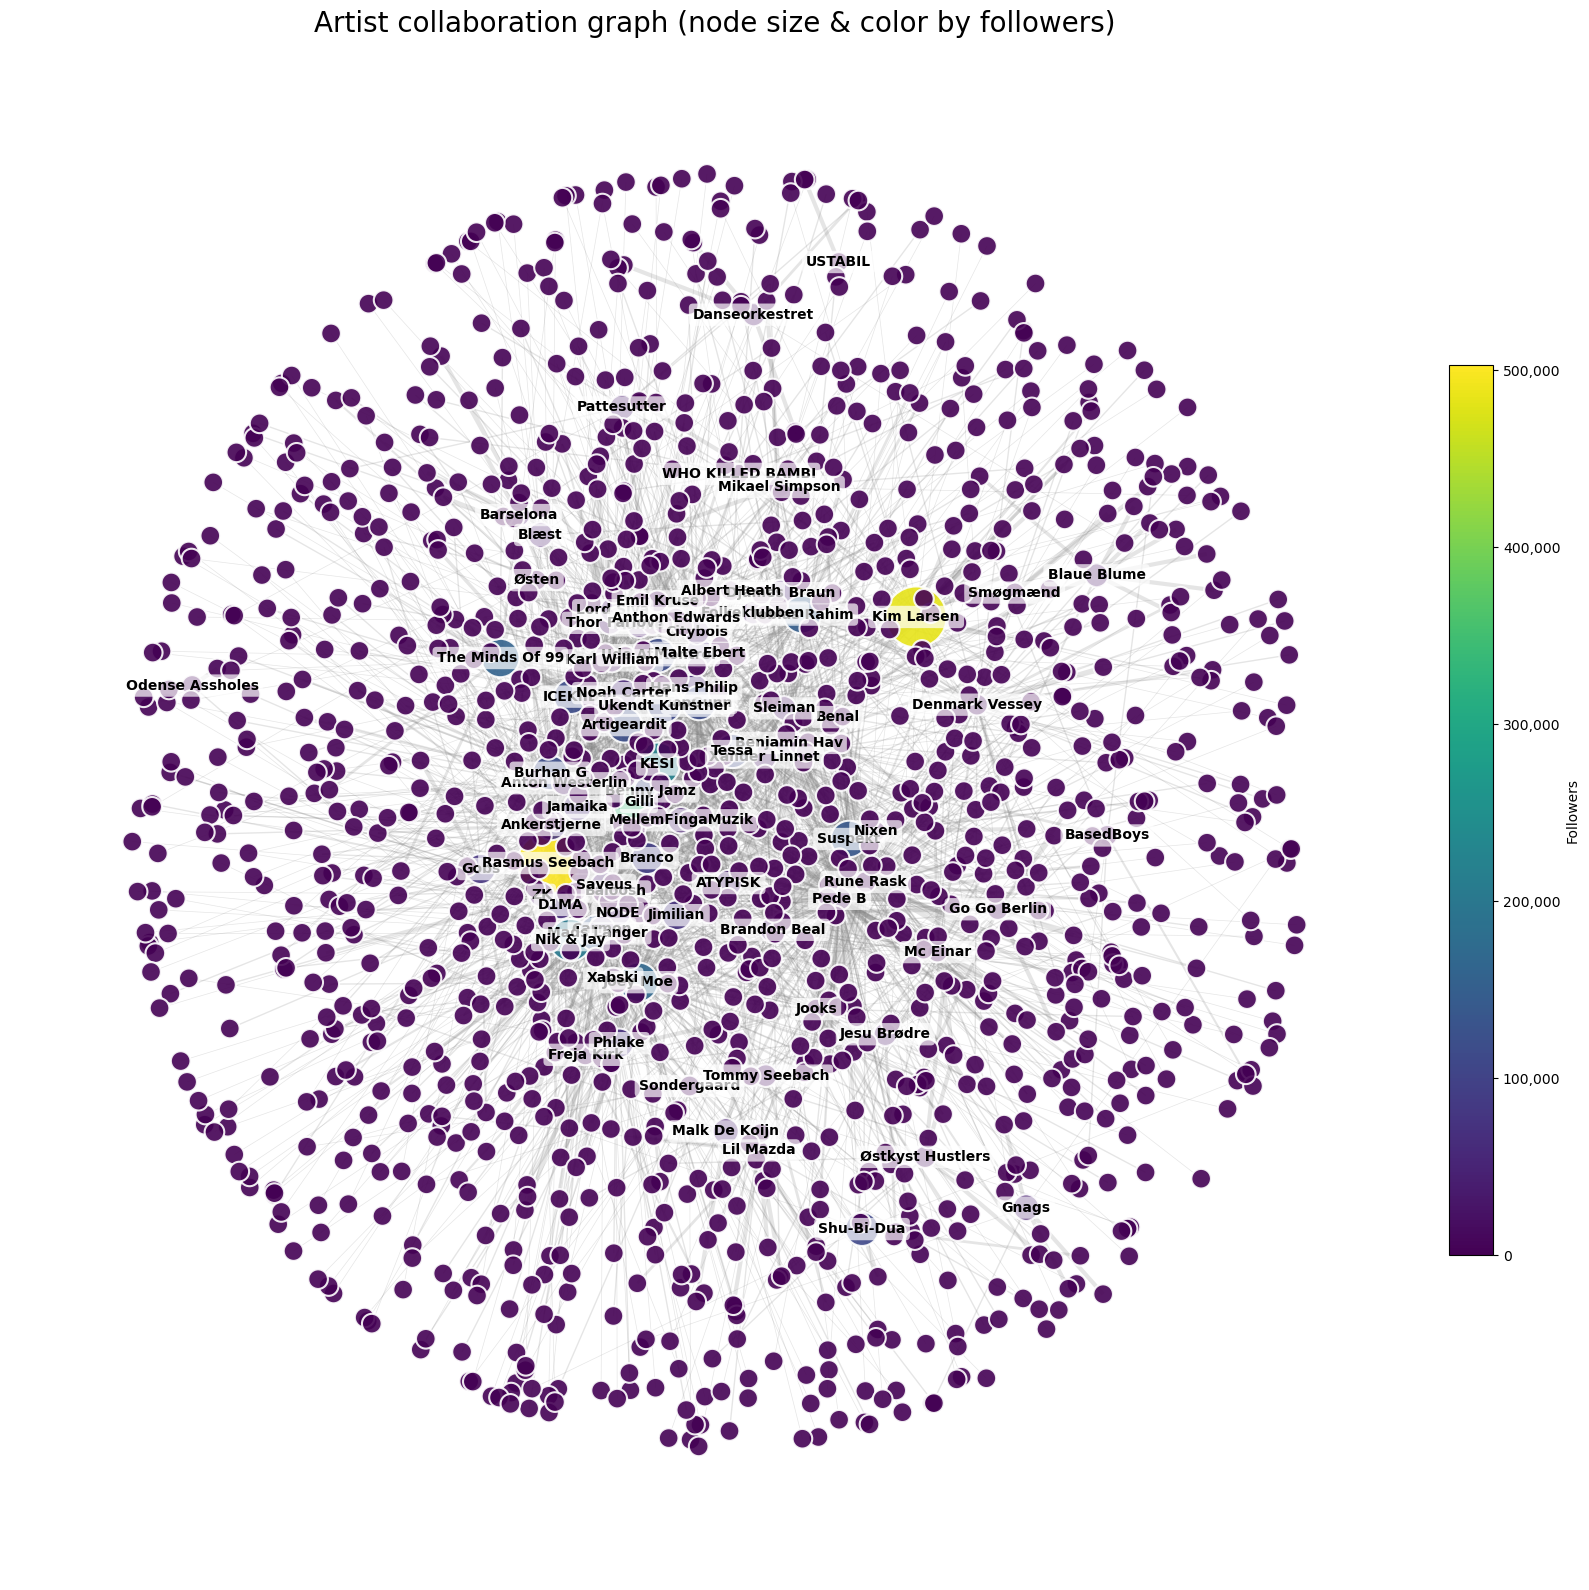

In [126]:
draw_graph_notlog(G, figsize=(16, 16), label_top_n=50)

### Network node analysis

Now let's analyze the artists in our network to understand who are the most influential nodes based on different metrics.

#### Most Popular Artists (by Spotify Followers)

Follower count is a direct measure of mainstream popularity and reach.

In [16]:
# Print top 5 artists by followers
followers = nx.get_node_attributes(G, "followers")
# Sort by follower count (descending)
top_artists = sorted(followers.items(), key=lambda x: x[1], reverse=True)[:5]
# Display top artists
print("Top 5 artists by followers:")
for artist, count in top_artists:
    print(f"{artist}: {count} followers")

Top 5 artists by followers:
Rasmus Seebach: 502789 followers
Kim Larsen: 483360 followers
Gilli: 339104 followers
KESI: 221496 followers
Nik & Jay: 203950 followers


#### Network Composition Analysis

Our network contains two types of nodes:
- **Seed nodes**: Core Danish artists from our Spotify search
- **Featured nodes**: Collaborators discovered through songs
 
Let's analyze the composition and understand how much our network expanded through collaboration discovery.

In [17]:
# Separate nodes by type
seeds = [n for n, attrs in G.nodes(data=True) if attrs.get("type") == "seed"]
print(f"Number of seed nodes: {len(seeds)}")
print(f"Total nodes: {G.number_of_nodes()}")
# Calculate percentages
print(f"Seed nodes are {len(seeds)/G.number_of_nodes()*100:.1f}% of the graph")

Number of seed nodes: 80
Total nodes: 1460
Seed nodes are 5.5% of the graph


#### Network Connectivity Analysis

The **degree** of a node is the number of connections (edges) it has. In our collaboration network, this represents how many unique artists someone has collaborated with.

Analyzing the degree distribution helps us understand:
- How connected the network is overall
- Whether there are "hub" artists with many collaborations
- If the network follows a power-law distribution (scale-free property)

In [18]:
# Calculate degree for all nodes
degrees = [val for (node, val) in G.degree()]
# Average degree across all nodes
avg_degree = sum(degrees) / len(degrees)
print(f"Average degree: {avg_degree:.2f}")

Average degree: 3.77


#### Centrality Analysis

**Centrality measures** identify the most "important" or "influential" nodes in a network. Different centrality metrics capture different aspects of importance:

- **Degree Centrality**: Proportion of nodes directly connected to (collaboration reach)
- **Betweenness Centrality**: How often a node lies on shortest paths (bridging role)
 
We'll calculate both centrality measures to identify key artists from different perspectives.

##### 1. Degree Centrality

**Definition**: The fraction of nodes in the network that a node is connected to.
 
**Interpretation**: Artists with high degree centrality collaborate with a large proportion of the network. They have broad collaborative reach.

**Formula**: C_D(v) = degree(v) / (N - 1), where N is total number of nodes


In [19]:
# Degree centrality
centralities_dict = nx.degree_centrality(G)
# Sorting in descending order
sorted_c = sorted(centralities_dict.items(), key=lambda kv: kv[1], reverse=True)
print("Top 5 central characters according to degree centrality:")
for node, cent in sorted_c[:5]:
    print(f"{node}: {cent:.4f}")

Top 5 central characters according to degree centrality:
Pede B: 0.1282
Rune Rask: 0.0685
Branco: 0.0658
Joey Moe: 0.0596
Benjamin Hav: 0.0589


##### 2. Betweenness Centrality

**Definition**: The fraction of shortest paths between all node pairs that pass through a given node.

**Interpretation**: Artists with high betweenness act as "bridges" connecting different parts of the network. They facilitate connections between otherwise distant artists.

**Use case**: Identifies connectors who span different genres, generations, or communities.


In [81]:
# Bar chart or network visualization highlighting artists with highest betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
# Sorting in reverse order
sorted_b = sorted(betweenness_dict.items(), key=lambda kv: kv[1], reverse=True)

# Top 15 artists by betweenness centrality
top_betweenness = sorted_b[:15]
artists, betweenness_values = zip(*top_betweenness)
# Visualizing
plt.figure(figsize=(12, 6))
plt.barh(artists, betweenness_values, color='skyblue')
plt.xlabel('Betweenness centrality')
plt.title('Top 15 artists by betweenness centrality')
plt.gca().invert_yaxis()
plt.show()

### Degree distribution: Scale-Free network analysis

The **degree distribution** P(k) shows the probability that a randomly selected node has degree k. In many real-world networks, including social networks, this distribution follows a **power law**: P(k) ~ k^(-γ)

**Key characteristics:**
- **Power-law distribution** (straight line on log-log plot) indicates a scale-free network
- **Scale-free networks** have a few highly connected "hubs" and many low-degree nodes
- **Exponent γ** typically ranges from 2-3 for real-world networks

This is fundamentally different from random networks, where most nodes have similar degrees.


In [27]:
# Distribution of node degrees (log-log plot)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

# Use Counter for more accurate frequency counting
degree_counts = Counter(degree_sequence)
degrees = np.array(sorted(degree_counts.keys()))
frequencies = np.array([degree_counts[d] for d in degrees])

# Create figure with better styling
plt.figure(figsize=(10, 7))

# Plot with improved aesthetics
plt.loglog(degrees, frequencies, 'o', 
           markersize=8, 
           markerfacecolor='#2E86AB',
           markeredgecolor='#1A5276',
           markeredgewidth=1.5,
           alpha=0.7,
           label='Observed')

# adding power-law reference line
if len(degrees) > 1:
    log_degrees = np.log10(degrees)
    log_freq = np.log10(frequencies)
    coeffs = np.polyfit(log_degrees, log_freq, 1)
    gamma = -coeffs[0]
    
    # making reference line
    x_fit = np.logspace(np.log10(degrees.min()), np.log10(degrees.max()), 100)
    y_fit = 10**coeffs[1] * x_fit**coeffs[0]
    
    plt.loglog(x_fit, y_fit, '--', 
               color='#E63946', 
               linewidth=2, 
               alpha=0.6,
               label=f'Power law fit (γ ≈ {gamma:.2f})')

# styling improvements
plt.title("Degree distribution (log-log scale)", fontsize=16, pad=20)
plt.xlabel("Degree", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.grid(True, which="both", ls="-", alpha=0.3, linewidth=0.5)
plt.legend(fontsize=11, framealpha=0.9, loc='best')

# adding grid
plt.grid(True, which="minor", ls=":", alpha=0.2)

# tick labels
plt.tick_params(axis='both', which='major', labelsize=11)
plt.tick_params(axis='both', which='minor', labelsize=9)

# statistics text box
stats_text = f"Total nodes: {len(degree_sequence)}\n"
stats_text += f"Max degree: {max(degree_sequence)}\n"
stats_text += f"Mean degree: {np.mean(degree_sequence):.2f}\n"
stats_text += f"Median degree: {np.median(degree_sequence):.2f}"

plt.text(0.02, 0.02, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

#plt.savefig("images/degree_distribution_danish_artists.png", dpi=300)

<Figure size 640x480 with 0 Axes>

### Small-world network analysis

A **small-world network** has two key properties:
1. **Short average path length** - similar to random networks (nodes are close)
2. **High clustering coefficient** - much higher than random (friends of friends are friends)
 
This combination of "six degrees of separation" + local clustering is characteristic of many social networks and enables efficient information spread while maintaining community structure.

We'll compare our collaboration network with an **Erdős-Rényi (ER) random graph** that has the same number of nodes and edges.

In [31]:
# Comparing to ER random graph using largest connected component
if nx.is_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    G_connected = G
else:
    # Get the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_connected = G.subgraph(largest_cc).copy()
    avg_path_length = nx.average_shortest_path_length(G_connected)
    print(f"Using largest connected component with {len(G_connected.nodes())} nodes")

N = G_connected.number_of_nodes()
M = G_connected.number_of_edges()
p = (2 * M) / (N * (N - 1))  # Probability of connection

print(f"\nDanish artist graph:")
print(f"Connection probability p: {p:.4f}")
print(f"Average shortest path length: {avg_path_length:.4f}")

# Create random graph with same N and p
G_random = nx.erdos_renyi_graph(N, p, seed=42)

# Ensure random graph is connected (if not, regenerate)
attempts = 0
while not nx.is_connected(G_random) and attempts < 10:
    G_random = nx.erdos_renyi_graph(N, p, seed=42 + attempts)
    attempts += 1

if nx.is_connected(G_random):
    avg_path_length_random = nx.average_shortest_path_length(G_random)
else:
    largest_cc_random = max(nx.connected_components(G_random), key=len)
    G_random_connected = G_random.subgraph(largest_cc_random).copy()
    avg_path_length_random = nx.average_shortest_path_length(G_random_connected)
    #print(f"Random graph largest component: {len(G_random_connected.nodes())} nodes")

print(f"\nShortest path length comparison:")
print(f"Random Graph (Erdős-Rényi):")
print(f"Average shortest path length: {avg_path_length_random:.4f}")

print(f"\nClustering coefficient comparison:")
C_random = nx.average_clustering(G_random)
print(f"Average clustering coefficient (Danish artist graph): {C:.4f}")
print(f"Average clustering coefficient (Random graph): {C_random:.4f}")

Using largest connected component with 1419 nodes

Danish artist graph:
Connection probability p: 0.0027
Average shortest path length: 3.9020

Shortest path length comparison:
Random Graph (Erdős-Rényi):
Average shortest path length: 5.5812

Clustering coefficient comparison:
Average clustering coefficient (Danish artist graph): 0.1496
Average clustering coefficient (Random graph): 0.0028


### Community detection analysis

**Community detection** identifies groups of nodes that are more densely connected to each other than to the rest of the network. In our collaboration network, communities might represent:
- **Genre clusters** (hip-hop artists, pop artists, rock artists)
- **Regional groups** (Copenhagen scene, Aarhus scene)
- **Record label affiliations** (artists on the same label)
- **Generational cohorts** (artists active in the same era)
 
We'll use the **Louvain algorithm**, which optimizes **modularity** - a measure of how well the network divides into communities.

In [32]:
# Check if Louvain communities are distinct
communities = {}

# calcualte louvain communities 
louvain = nx.community.louvain_communities(G)
for i, community in enumerate(louvain):
    for node in community:
        communities[node] = i

nx.set_node_attributes(G, communities, 'louvain_community')

# Check distinct communities
community_counts = {}
for node, data in G.nodes(data=True):
    community = data.get('louvain_community')
    if community is not None:
        community_counts[community] = community_counts.get(community, 0) + 1

print(f"Total Louvain communities found: {len(community_counts)}")
print(f"Maximum community size: {max(community_counts.values())}")
print(f"Average community size: {len(G.nodes)/len(community_counts):.2f}")
print(f"Minimum community size: {min(community_counts.values())}")

Total Louvain communities found: 25
Maximum community size: 181
Average community size: 58.40
Minimum community size: 2


### Temporal network analysis

The Danish music scene has evolved significantly over the past 25 years. By partitioning our network into **5-year time windows**, we can:
- Track how collaboration patterns have changed over time
- Identify emerging vs. declining artists
- Measure network growth and densification
- Detect shifts in community structure
- Analyze temporal trends in centrality
 
We'll create 5 sub-networks based on song release dates:
- **2000-2005**: Early digital era
- **2005-2010**: Rise of streaming
- **2010-2015**: Mobile music explosion
- **2015-2020**: Streaming dominance
- **2020-2025**: Contemporary era

In [63]:
# This function extracts a subgraph containing only edges (collaborations) from songs released within a specific time window.
def filter_graph_by_edge_date_range(G, start_year, end_year, inclusive=True):
    """
    Extract subgraph with edges from a specific time period.
    
    Args:
        G (nx.Graph): Original graph with 'dates' attribute on edges
        start_year (int): Start year (inclusive)
        end_year (int): End year (inclusive if inclusive=True, else exclusive)
        inclusive (bool): Whether end_year is inclusive (default: True)
    
    Returns:
        nx.Graph: Subgraph containing only edges from the specified period
    
    Note:
        - Nodes are included if they have at least one edge in the period
        - Node attributes are preserved from the original graph
        - Edge attributes (weight, dates) are preserved
    """
    H = nx.Graph()
    
    # check if no already in new graph H
    def ensure_node(u):
        if not H.has_node(u):
            H.add_node(u, **G.nodes[u])
    
    edges_matched = 0
    
    # using dates attribute on edges
    for u, v, d in G.edges(data=True):
        dates = d.get("dates")
        
        if not dates:
            continue
        
        # Parse JSON string to list
        if isinstance(dates, str):
            try:
                dates = json.loads(dates)
            except json.JSONDecodeError:
                # If it's not valid JSON, try treating it as a single date
                dates = [dates]
        elif not isinstance(dates, list):
            dates = [dates]
        
        matched = False
        for date_str in dates:
            try:
                # Extract year from ISO date string (YYYY-MM-DD)
                year = int(date_str.split("-")[0])
                
                if inclusive:
                    if start_year <= year <= end_year:
                        matched = True
                        break
                else:
                    if start_year <= year < end_year:
                        matched = True
                        break
            except (ValueError, AttributeError, TypeError, IndexError):
                continue
        
        if matched:
            edges_matched += 1
            ensure_node(u)
            ensure_node(v)
            H.add_edge(u, v, **d)
    
    print(f"Period {start_year}-{end_year}: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")
    
    return H


# Apply the filtering in the 5-year intervals
G_2000_2005 = filter_graph_by_edge_date_range(G, 2000, 2005)
G_2005_2010 = filter_graph_by_edge_date_range(G, 2005, 2009)
G_2010_2015 = filter_graph_by_edge_date_range(G, 2010, 2014)
G_2015_2020 = filter_graph_by_edge_date_range(G, 2015, 2019)
G_2020_2025 = filter_graph_by_edge_date_range(G, 2020, 2025)

Period 2000-2005: 67 nodes, 74 edges
Period 2005-2009: 109 nodes, 128 edges
Period 2010-2014: 416 nodes, 679 edges
Period 2015-2019: 594 nodes, 950 edges
Period 2020-2025: 773 nodes, 1330 edges


### Visual comparison of temporal networks

Now we'll create side-by-side visualizations of each time period to visually compare:
- Network density and structure evolution
- Artist prominence (node size = followers)
- Collaboration intensity (edge thickness = frequency)
- Hub formation and community clustering
 
This visual analysis complements the quantitative metrics we calculated earlier.


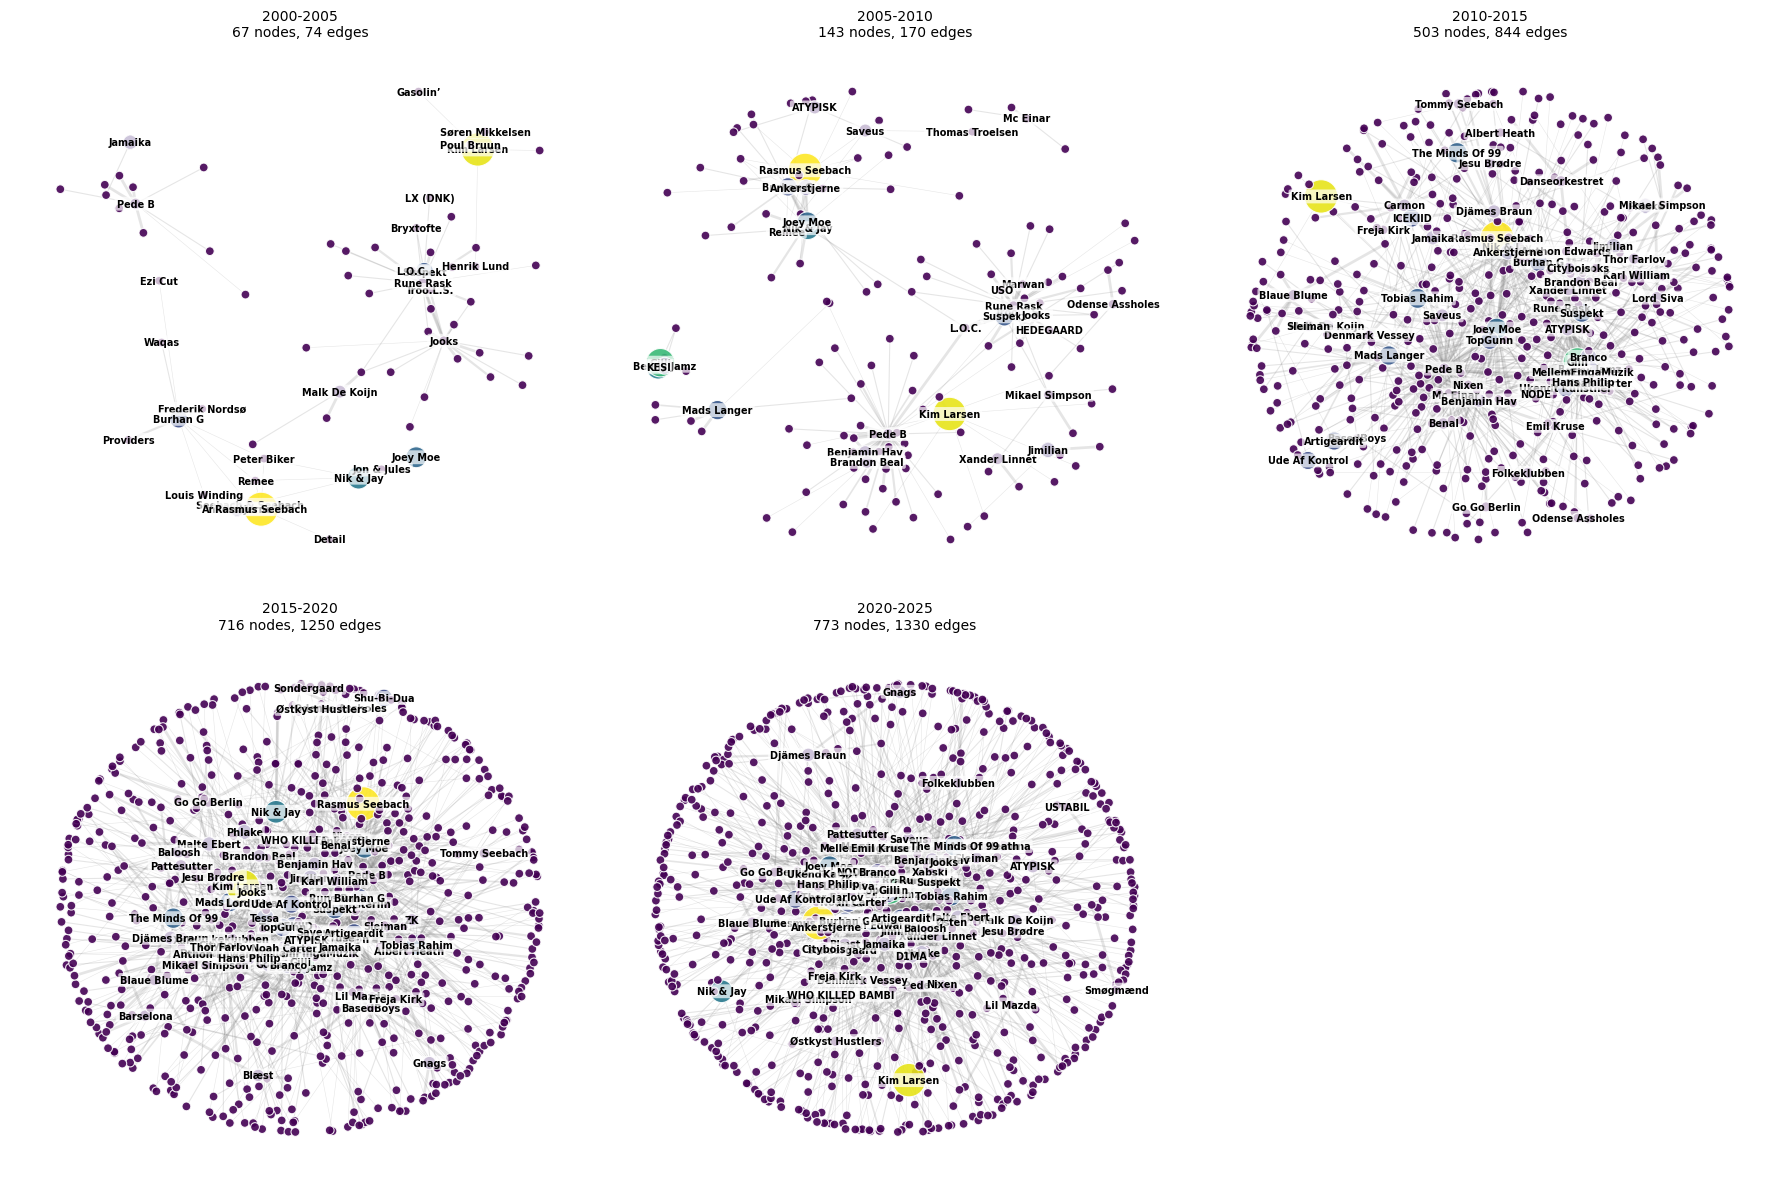

In [ ]:
# Not log-scaled node sizing (linear) and subplot-ready ax version
def draw_graph_notlog_on_ax(G, ax, label_top_n=20, seed=42, min_size=40, max_size=600):
    """
    Draw network graph on a matplotlib axis (for subplots).
    
    Args:
        G (nx.Graph): Network to visualize
        ax (matplotlib.axes.Axes): Axis to draw on
        label_top_n (int): Number of top artists to label
        seed (int): Random seed for reproducible layout
        min_size (int): Minimum node size in points
        max_size (int): Maximum node size in points
    
    Features:
        - Node size/color: Linear scale by Spotify followers
        - Edge width: Proportional to collaboration count
        - Labels: Seed artists + top N by followers
        - Handles empty graphs gracefully
    """
    ax.clear()
    if G is None or G.number_of_nodes() == 0:
        ax.text(0.5, 0.5, "Empty graph", ha="center", va="center")
        ax.set_axis_off()
        return

    pos = nx.spring_layout(G, k=2.0, iterations=300, seed=seed, scale=2)

    # node size by follower count (linear scaling)
    followers = nx.get_node_attributes(G, "followers")
    follower_counts = [followers.get(n, 0) for n in G.nodes()]
    min_f = min(follower_counts) if follower_counts else 0
    max_f = max(follower_counts) if follower_counts else 1

    # linear node sizing (no log)
    node_sizes = []
    for n in G.nodes():
        f = followers.get(n) or 0
        if max_f > min_f:
            size = min_size + (f - min_f) / (max_f - min_f) * (max_size - min_size)
        else:
            size = min_size
        node_sizes.append(size)

    # color mapping (linear on followers)
    cmap = plt.cm.viridis
    if follower_counts:
        vmin, vmax = min(follower_counts), max(follower_counts)
    else:
        vmin, vmax = 0.0, 1.0
    if vmin == vmax:
        vmin = 0.0
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    node_colors = [cmap(norm(followers.get(n) or 0)) for n in G.nodes()]

    edge_weights = [d.get("weight", 1) for _, _, d in G.edges(data=True)]
    edge_widths = [max(0.2, min(2.0, 0.4 * w)) for w in edge_weights]

    nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_widths, edge_color='gray', ax=ax)
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           alpha=0.9,
                           linewidths=0.8,
                           edgecolors='white',
                           ax=ax)

    # labels: seeds + top follower nodes
    seeds = [n for n, a in G.nodes(data=True) if a.get("type") == "seed"]
    top_followers = sorted(G.nodes(), key=lambda n: followers.get(n, 0), reverse=True)[:label_top_n]
    label_nodes = set(seeds) | set(top_followers)
    labels = {n: n for n in label_nodes if n in G.nodes()}

    nx.draw_networkx_labels(G, pos, labels,
                            font_size=7,
                            font_weight='bold',
                            font_color='black',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7),
                            ax=ax)

    ax.set_axis_off()

# prepare list of graphs and titles (use the non-log ax drawer)
graphs = [
    (G_2000_2005, "2000-2005"),
    (G_2005_2010, "2005-2010"),
    (G_2010_2015, "2010-2015"),
    (G_2015_2020, "2015-2020"),
    (G_2020_2025, "2020-2025")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (g, title) in enumerate(graphs):
    draw_graph_notlog_on_ax(g, axes[i], label_top_n=30, seed=42, min_size=40, max_size=600)
    axes[i].set_title(f"{title}\n{g.number_of_nodes()} nodes, {g.number_of_edges()} edges", fontsize=10)

# hide unused subplot (6th)
axes[-1].set_axis_off()
plt.tight_layout()
plt.show()

### Top collaborators across time periods

Let's identify the most collaborative artists in each time period and compare them to understand:
- **Persistence**: Which artists remain central across multiple eras?
- **Emergence**: Which new artists rise to prominence in later periods?
- **Temporal patterns**: How has the "top tier" of collaborators changed?
- **Network hubs**: Who are the consistently most connected artists?
 
We'll rank artists by **degree** (number of unique collaborators) in each period.


In [65]:
# Print top 5 artists by degree (number of collaborations)
graphs = {
    "all": G,
    "2000-2005": G_2000_2005,
    "2005-2010": G_2005_2010,
    "2010-2015": G_2010_2015,
    "2015-2020": G_2015_2020,
    "2020-2025": G_2020_2025,
}

# Top collaborators analysis function
def top_by_degree(G, n=10):
    """
    Get top N artists by degree (number of collaborators).
    
    Args:
        G (nx.Graph): Network to analyze
        n (int): Number of top artists to return
    
    Returns:
        list: Artist names with degrees, formatted as "Name (degree)"
    """
    if G is None or G.number_of_nodes() == 0:
        return ["(empty)"] * n
    deg = dict(G.degree())
    items = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:n]
    return [f"{name} ({d})" for name, d in items]

top_n = 10
df_top = pd.DataFrame({label: top_by_degree(g, top_n) for label, g in graphs.items()})
df_top.index = range(1, top_n + 1)

display(df_top)

all              2000-2005           2005-2010  \
1           Pede B (187)         Rune Rask (19)         Pede B (30)   
2        Rune Rask (100)             Jooks (16)      Rune Rask (28)   
3            Branco (96)             Pede B (9)       Nik & Jay (9)   
4          Joey Moe (87)           Burhan G (8)  Rasmus Seebach (8)   
5      Benjamin Hav (86)            Suspekt (5)        Burhan G (8)   
6          Burhan G (81)         Kim Larsen (5)         Suspekt (7)   
7           TopGunn (79)     Rasmus Seebach (4)      Kim Larsen (7)   
8             Gilli (78)  Seebach & Seebach (4)    Ankerstjerne (6)   
9   Anton Westerlin (74)          Nik & Jay (4)     Mads Langer (6)   
10             KESI (72)          Troo.L.S. (3)           Jooks (6)   

               2010-2015           2015-2020             2020-2025  
1            Pede B (84)         Pede B (71)  Anton Westerlin (71)  
2          Joey Moe (53)      Rune Rask (36)           Pede B (60)  
3             Gilli (40)         Carmon (36)           Branco (55)  
4           ATYPISK (35)        TopGunn (36)      Artigeardit (51)  
5            Branco (34)       Burhan G (33)     Benjamin Hav (49)  
6              KESI (33)   Ankerstjerne (31)     Tobias Rahim (45)  
7        Benny Jamz (31)   Brandon Beal (30)            Tessa (45)  
8       Hans Philip (28)  Xander Linnet (28)             KESI (43)  
9   Ukendt Kunstner (27)          Gilli (28)          ICEKIID (40)  
10         Mc Einar (27)       Joey Moe (28)      Noah Carter (38)

### Network backbone extraction

Real-world networks often contain many weak or noisy connections that obscure the core structure. **Backbone extraction** identifies the most significant edges while filtering out less important connections.

We'll use the **disparity filter** method, which:
- Tests whether each edge's weight is statistically significant
- Compares edge weight to the node's total connectivity
- Preserves edges that carry disproportionately high weight
- Removes edges that appear consistent with random chance


In [82]:
# Step 1: Prepare Network for Backbone Extraction
# Converting GraphML to TSV with degree weights
def graphml_to_tsv_degree(graphml_file, output_file):
    """
    Convert GraphML network to TSV format with degree-based edge weights.
    
    Args:
        graphml_file (str): Path to input GraphML file
        output_file (str): Path to output TSV file
    
    Process:
        1. Load network from GraphML
        2. Calculate degree for each node
        3. Weight each edge by sum of endpoint degrees
        4. Export as TSV (required format for backbone library)
    
    Returns:
        None (writes to file)
    """
    G = nx.read_graphml(graphml_file)
    degrees = dict(G.degree())
    
    edges = []
    for src, trg in G.edges():
        weight = degrees[src] + degrees[trg]
        edges.append({'src': src, 'trg': trg, 'degree': weight})
    
    df = pd.DataFrame(edges)
    df.to_csv(output_file, sep='\t', index=False)
    print(f"Converted {len(edges)} edges with degree-based weights")

# Convert and reading for backboning
graphml_to_tsv_degree('danish_collaboration_graph_GPU.graphml', 
                      'GPU_graph_degree.tsv')

# Step 2: Apply Disparity Filter

# The disparity filter calculates a statistical score for each edge:
# - **High score**: Edge weight is unusually high for these nodes (significant)
# - **Low score**: Edge weight is consistent with random distribution (noise)

table, nnodes, nedges = backboning.read("GPU_graph_degree.tsv", "degree")

# Disparity filter for backboning
df_table = backboning.disparity_filter(table)

# Visualize score distribution
plt.figure(figsize=(10, 4))

# Subplot 1: Histogram of scores
plt.subplot(1, 2, 1)
plt.hist(df_table['score'], bins=50, edgecolor='black')
plt.xlabel('Disparity filter score')
plt.ylabel('Frequency')
plt.title('Score distribution')

# Subplot 2: Cumulative distribution
plt.subplot(1, 2, 2)
plt.hist(df_table['score'], bins=50, cumulative=True, density=True, edgecolor='black')
plt.xlabel('Disparity filter score')
plt.ylabel('Cumulative probability')
plt.title('Cumulative distribution')
plt.axhline(y=0.95, color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.tight_layout()
plt.show()

# Applying 95th percentile threshold
threshold_95 = df_table['score'].quantile(0.95)
df_backbone = backboning.thresholding(df_table, threshold=threshold_95)

# Creating graph
G_backbone = nx.from_pandas_edgelist(
    df_backbone,
    source='src',
    target='trg',
    edge_attr=['nij', 'score'],
    create_using=nx.Graph()
)

print(f"Backbone graph: {G_backbone.number_of_nodes()} nodes, {G_backbone.number_of_edges()} edges")

Converted 2754 edges with degree-based weights


Calculating DF score...


Backbone graph: 59 nodes, 138 edges


### Visualization of backbone

For a prettier visualization of the backbone found above, we add the Spotify followers count as a node attribute.

In [83]:
followers_dict = nx.get_node_attributes(G, "followers")
nx.set_node_attributes(G_backbone, followers_dict, "followers")

print(f"Added 'followers' attribute to {G_backbone.number_of_nodes()} nodes in G_backbone")

Added 'followers' attribute to 59 nodes in G_backbone


### Backbone network connectivity analysis

After extracting the backbone, we need to verify its connectivity properties. Since backbone extraction removes many edges, the network may fragment into multiple disconnected components.

In [118]:
# Check the largest component
largest_cc = max(nx.connected_components(G_backbone), key=len)
print(f"Largest component has {len(largest_cc)} nodes")

# Average shortest path in largest component
G_largest = G_backbone.subgraph(largest_cc).copy()
if nx.is_connected(G_largest):
    avg_path_length_largest = nx.average_shortest_path_length(G_largest)
    print(f"Average shortest path length in largest component: {avg_path_length_largest:.4f}")

Largest component has 57 nodes
Average shortest path length in largest component: 3.1297


### Visualize network backbone

Now we'll create a high-quality visualization of the extracted backbone network. This should be much clearer than the full network visualization since we've removed ~95% of edges, leaving only the most statistically significant collaborations.

**Visual encoding:**
- **Node size**: Spotify follower count (larger = more popular)
- **Node color**: Also by follower count (yellow = high, purple = low)
- **Edge thickness**: Collaboration frequency (thicker = more songs together)
- **Labels**: Core Danish artists + top artists by followers

In [ ]:
# Backbone Visualization Function
def draw_backbone_notlog(G, figsize=(16, 16), label_top_n=20, seed=42):
    plt.close('all')
    fig, ax = plt.subplots(figsize=figsize)

    # Better layout with more separation
    pos = nx.spring_layout(
        G,
        k=2.0,
        iterations=500,
        seed=seed,
        scale=2
    )

    # Degree (for fallback sizing)
    deg = dict(G.degree())

    # Size by follower count (linear scaling)
    followers = nx.get_node_attributes(G, "followers")
    follower_counts = [followers.get(n, 0) for n in G.nodes()]
    min_f = min(follower_counts) if follower_counts else 0
    max_f = max(follower_counts) if follower_counts else 1

    min_size = 200    # smallest marker size
    max_size = 2000   # largest marker size

    node_sizes = []
    for n in G.nodes():
        f = followers.get(n) or 0
        if max_f > min_f:
            # linear normalization (no log)
            size = min_size + (f - min_f) / (max_f - min_f) * (max_size - min_size)
        else:
            size = min_size
        node_sizes.append(size)

    # Map followers -> colors (keep log color mapping or change if desired)
    log_vals = [math.log10(v + 1) for v in follower_counts]
    vmin, vmax = (min(log_vals), max(log_vals)) if log_vals else (0.0, 1.0)

    if vmin == vmax:
        vmin = 0.0
    

    norm = mcolors.Normalize(vmin=min_f, vmax=max_f)
    
    #norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.viridis
    #node_colors = [cmap(norm(math.log10((followers.get(n) or 0) + 1))) for n in G.nodes()]
    node_colors = [cmap(norm(followers.get(n) or 0)) for n in G.nodes()]

    # Edge widths by weight
    edge_weights = [d.get("weight", 1) for _, _, d in G.edges(data=True)]
    edge_widths = [max(0.3, min(3, 0.5 * w)) for w in edge_weights]  # Thinner edges

    # Draw edges first (on ax)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_widths, edge_color='gray', ax=ax)

    # Draw nodes grouped by type (on ax)
    nlist = [n for n, attrs in G.nodes(data=True)]
    nlist_sizes = [node_sizes[list(G.nodes()).index(n)] for n in nlist]

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nlist,
        node_size=nlist_sizes,
        node_color=node_colors,
        alpha=0.9,
        linewidths=1.5,
        edgecolors='white',
        ax=ax
    )

    # Add colorbar (attach to figure using the same ax)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Followers")
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    # Smart labeling: seeds + top follower nodes
    seeds = [n for n, a in G.nodes(data=True) if a.get("type") == "seed"]
    top_followers = sorted(G.nodes(), key=lambda n: followers.get(n, 0), reverse=True)[:label_top_n]
    label_nodes = set(seeds) | set(top_followers)
    labels = {n: n for n in label_nodes}

    nx.draw_networkx_labels(
        G, pos, labels,
        font_size=10,
        font_weight='bold',
        font_color='black',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7),
        ax=ax
    )

    ax.set_axis_off()
    plt.title(f"Artist backbone graph (node size & color by followers) \n {len(G.nodes())} nodes, {len(G.edges())} edges", fontsize=20)
    plt.tight_layout()
    plt.show()

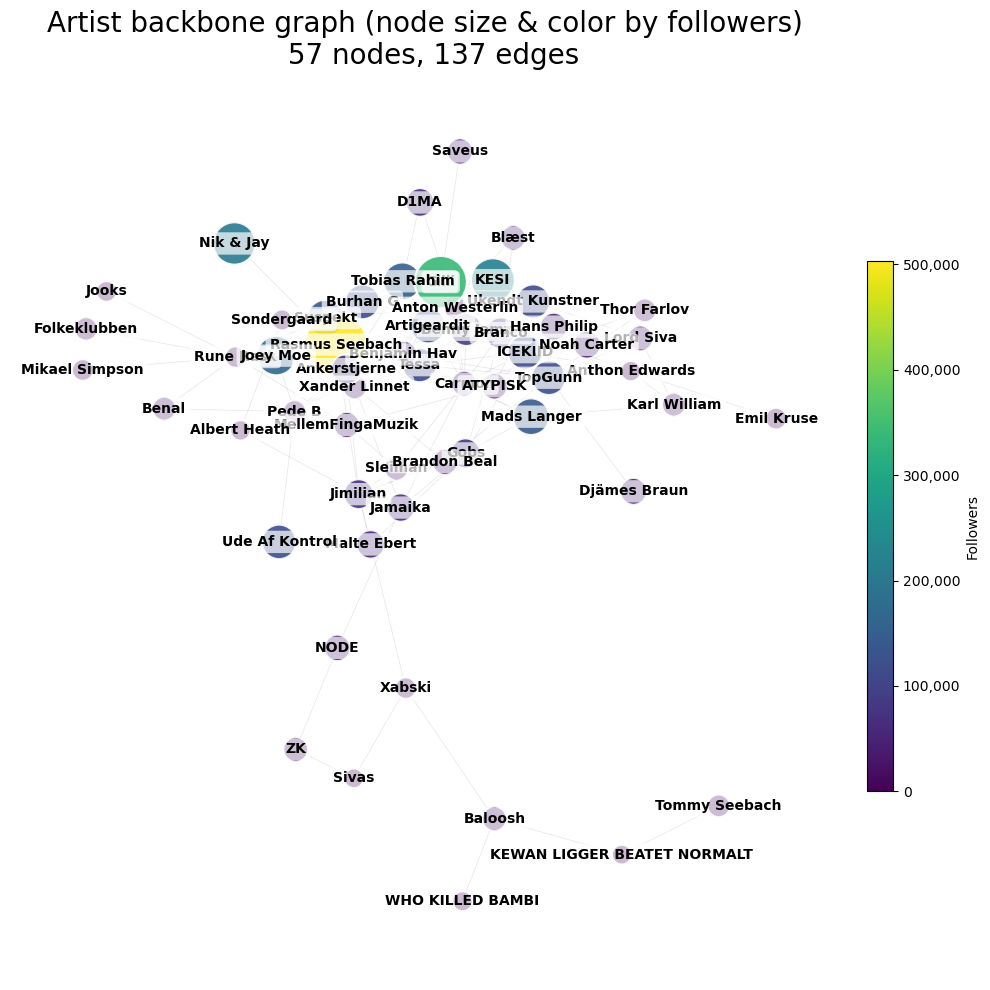

In [ ]:
# Getting largest connected component of backbone for visualization
largest_cc_backbone = max(nx.connected_components(G_backbone), key=len)
# Create subgraph of largest connected component
G_backbone_cc = G_backbone.subgraph(largest_cc_backbone).copy()

draw_backbone_notlog(G_backbone_cc, figsize=(10, 10), label_top_n=100, seed=42)

### Backbone network: Key artists analysis

Now that we've extracted and visualized the backbone, let's identify which artists are most central in this **core collaboration network**.

Artists who remain highly connected in the backbone are:
- **Structurally important**: Their collaborations are statistically significant
- **Persistent collaborators**: They work repeatedly with key partners
- **Network hubs**: They connect different parts of the music scene
 
This is different from the full network, where some high-degree artists may have many weak/random collaborations that don't survive backbone extraction.


In [108]:
degrees_backbone = dict(G_backbone.degree())

# Find top 5 nodes by degree in backbone graph
top_5_backbone = sorted(degrees_backbone.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by degree in backbone graph:")
for node, deg in top_5_backbone:
    print(f"{node}: {deg}")

Top 5 nodes by degree in backbone graph:
Branco: 13
Anton Westerlin: 12
Artigeardit: 11
TopGunn: 11
Benjamin Hav: 10


### Sentiment analysis of danish lyrics

Now we shift our focus from **network structure** (who collaborates with whom) to **lyrical content** (what artists are saying).

We'll analyze the emotional tone of Danish song lyrics using sentiment analysis:
- **Sentiment polarity**: Are lyrics positive, negative, or neutral?
- **Temporal trends**: Has sentiment changed over time?
- **Artist differences**: Do different artists have distinct emotional styles?
- **Network relationships**: Is there correlation between collaboration patterns and sentiment?
 
This analysis complements the network structure by adding a content-based dimension to understanding the Danish music scene.

In [ ]:
# Sentiment analysis dataset load
column_names = ['headword', '', 'type', 'id', 'polarity', 'headword_variants']
# Load Danish Sentiment Lexicon
df = pd.read_csv('2_headword_headword_polarity.csv', names=column_names)

### Extract lyrics from Songs

Now we'll scrape lyrics from Genius for all songs in our dataset. For each song, we need to:

1. **Check release date**: Only include songs from 2000 onwards (matching our network timeframe)
2. **Scrape lyrics**: Use Genius API to fetch full lyrics text
3. **Organize by artist and year**: Store lyrics for temporal and artist-level analysis
 
This will enable us to:
- Analyze sentiment trends over time (2000-2025)
- Compare sentiment across different artists
- Correlate lyrical content with collaboration patterns

In [ ]:
# Saving lyrics for sentiment analysis
year_text = {}
artist_text = {}

# Count success and fails of lyrics scraping
count_fails = 0
count_success = 0

combined_sample = dict(list(combined_dict.items()))

# Loading for each artist in the combined sample from Spotify + Genius
for artist in combined_sample.keys():
    # Getting songs of artist
    top_song = combined_sample[artist]['top_songs']
    # For each song, get lyrics if released after 2000
    for son in top_song:
        if son['release_date_components'] == None:
            count_fails += 1
            continue

        year = son['release_date_components'].get('year')

        # only using lyrics released in or after 2000
        if year >= 2000:
            # get lyrics
            lyrics = genius.scrape_lyrics(son['url'])
            if lyrics:
                # store lyrics by year and artist
                year_text[year] = lyrics
                artist_text[artist] = lyrics
                count_success += 1
            else:
                count_fails += 1

### Calculate sentiment scores

Now we'll apply the Danish sentiment lexicon to our extracted lyrics. For each song's lyrics, we:

1. **Tokenize**: Split lyrics into individual words
2. **Match**: Look up each word in the sentiment lexicon
3. **Score**: Calculate average polarity of matched words
4. **Aggregate**: Compute average sentiment by year and by artist
 
**Important**: Only Danish words in the lexicon will be scored. English words, slang, and creative spellings will be ignored.

In [ ]:
# Calculating average sentiment scores both pr year and pr artist
avg_sentiment_scores = {}
avg_artist_scores = {}

# sentiment scores pr year
for year, text in year_text.items():
    all_texts = text.split()
    # apply sentiment analysis on words
    sentiment_scores = df[df['headword'].isin(all_texts)][['headword', 'polarity']]
    average_sentiment = sentiment_scores['polarity'].mean()
    # saving sentiment pr year
    avg_sentiment_scores[year] = average_sentiment

# sentiment scores pr artist
for artist, text in artist_text.items():
    all_texts = text.split()
    # apply sentiment analysis on words
    sentiment_scores = df[df['headword'].isin(all_texts)][['headword', 'polarity']]
    average_sentiment = sentiment_scores['polarity'].mean()
    # saving sentiment pr artist
    avg_artist_scores[artist] = average_sentiment

#### Inspecting the stored sentiment scores

In [96]:
# Access the two dictionaries
sentiment_by_year = data['list1']
sentiment_by_artist = data['list2']

# Convert to sorted lists if needed
years_sorted = sorted(sentiment_by_year.items(), key=lambda x: int(x[0]))

# Filter out NaN values from artists
artists_no_nan = {k: v for k, v in sentiment_by_artist.items() if not (isinstance(v, float) and math.isnan(v))}
print(f"Artists with valid scores: {len(artists_no_nan)}")

Artists with valid scores: 98


### Sentiment visualizations

We'll create visualizations of our sentiment analysis results with two specialized plotting functions:

1. **Sentiment by Year**: Shows temporal trends in lyrical sentiment
2. **Sentiment by Artist**: Compares sentiment across all artists

These visualizations include:
- Bar charts with clear visual encoding
- Reference lines for clean sentiment scores
- Value annotations for precise reading

In [ ]:
def plot_avg_sentiment_by_year(avg_sentiment_scores, ax=None):
    """
    Create bar chart of average sentiment by year.
    
    Args:
        sentiment_scores (dict): {year: sentiment_score}
        ax (matplotlib.axes.Axes): Existing axis to plot on (optional)
        figsize (tuple): Figure size if creating new figure
    
    Features:
        - Chronologically sorted years
        - Neutral reference line at y=0
        - Value annotations on each bar
    """
    # Prepare data
    pairs = [(k, v) for k, v in avg_sentiment_scores.items() if k is not None]

    def _try_int(x):
        try:
            return int(x)
        except (TypeError, ValueError):
            return x

    pairs = [(_try_int(k), v) for k, v in pairs]
    pairs = sorted(pairs, key=lambda x: x[0])

    years = [p[0] for p in pairs]
    values = [p[1] for p in pairs]

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_fig = True

    # Plot bars
    if all(isinstance(y, (int, float)) for y in years):
        ax.bar(years, values)
        ax.set_xticks(years)
    else:
        xpos = range(len(years))
        ax.bar(xpos, values)
        ax.set_xticks(xpos)
        ax.set_xticklabels(years, rotation=45, ha='right')

    # Horizontal line at neutral sentiment
    ax.axhline(0, linewidth=1, linestyle='--')

    # Titles and labels
    ax.set_title('Average Sentiment polarity by year', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Average sentiment polarity', fontsize=12)

    # Clean up spines and add grid
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle=':', linewidth=0.7)

    # Annotate bars with values (use current xticks)
    xticks = list(ax.get_xticks())
    for x, v in zip(xticks, values):
        ax.text(x, v + (0.03 * max(values) if values else 0.03) if (v is not None) else 0,
                f"{v:.2f}" if v is not None else "nan",
                ha='center', va='bottom', fontsize=8)

    if created_fig:
        fig.tight_layout()
        plt.show()


def plot_avg_sentiment_by_artist(avg_sentiment_scores, ax=None):
    """
    Create bar chart of average sentiment by artist.
    
    Args:
        sentiment_scores (dict): {artist: sentiment_score}
        ax (matplotlib.axes.Axes): Existing axis to plot on (optional)
        figsize (tuple): Figure size if creating new figure
        top_n (int): If specified, show only top N artists (sorted by absolute sentiment)
    
    Features:
        - Sorted by sentiment (most negative to most positive)
        - Color-coded bars (red=negative, green=positive)
        - Value annotations
    """
    # Prepare data
    pairs = [(k, v) for k, v in avg_sentiment_scores.items() if k is not None]

    def _try_int(x):
        try:
            return int(x)
        except (TypeError, ValueError):
            return x

    pairs = [(_try_int(k), v) for k, v in pairs]
    pairs = sorted(pairs, key=lambda x: x[0])

    labels = [p[0] for p in pairs]
    values = [p[1] for p in pairs]

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 6))
        created_fig = True

    xpos = range(len(labels))
    bars = ax.bar(xpos, values)
    ax.set_xticks(xpos)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=7)

    # Horizontal line at neutral sentiment
    ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)

    # Titles and labels
    ax.set_title('Average Sentiment polarity by artist', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Artist', fontsize=12)
    ax.set_ylabel('Average sentiment polarity', fontsize=12)

    # Clean up spines and add grid
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.5)

    # Annotate bars with values
    y_range = (max(values) - min(values)) if values else 1
    offset = 0.02 * y_range
    for bar, v in zip(bars, values):
        x = bar.get_x() + bar.get_width() / 2
        if v >= 0:
            y_pos = v + offset
            va = 'bottom'
        else:
            y_pos = v - offset
            va = 'top'
        ax.text(x, y_pos, f"{v:.2f}" if v is not None else "nan", ha='center', va=va, fontsize=7)

    if created_fig:
        fig.tight_layout()
        plt.show()

### Visualizing the sentiment scores in a subplot

For easier interpretation, the y-values are scaled equally in the plot that shows both sentiment scores per year and per artist.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


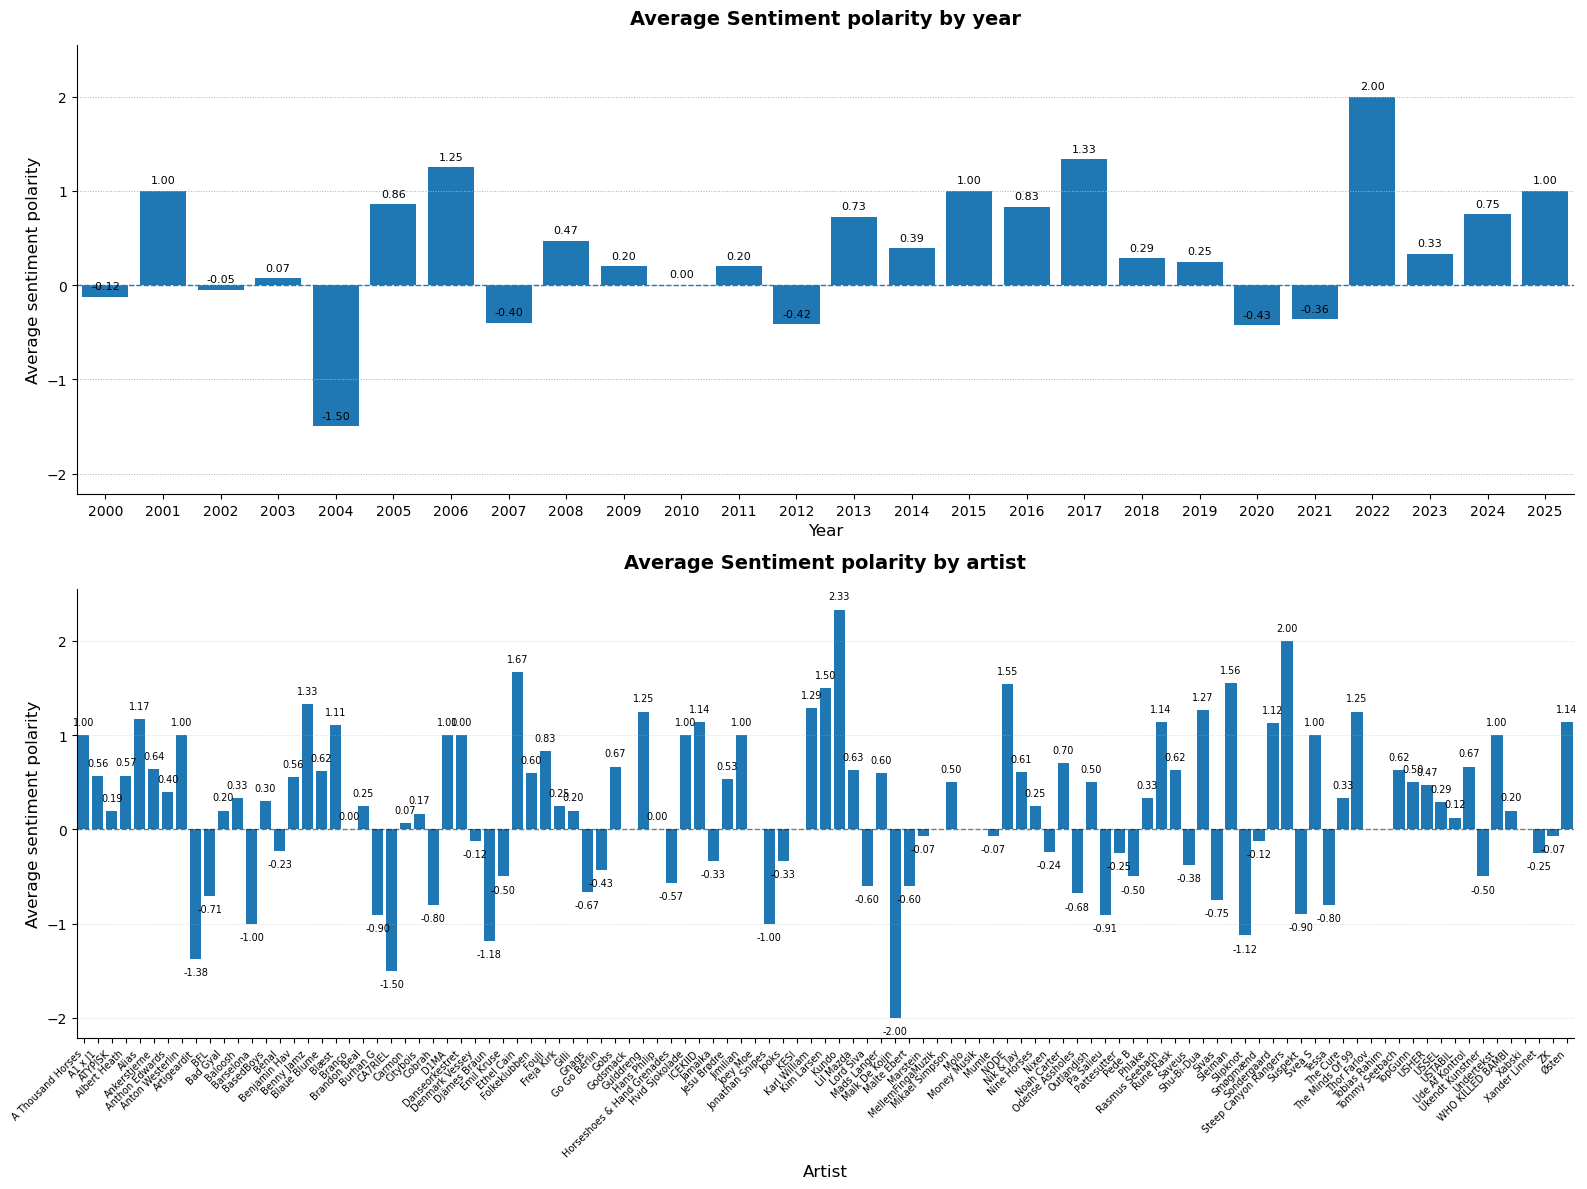

In [102]:
# Visualizing both plots in a single figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharey=True)

plot_avg_sentiment_by_year(sentiment_by_year, ax=ax1)
plot_avg_sentiment_by_artist(sentiment_by_artist, ax=ax2)

# compute common y-limits from both dictionaries (ignore None / NaN)
def _valid_vals(d):
    return [v for v in (d or {}).values() if v is not None and not (isinstance(v, float) and math.isnan(v))]

vals = _valid_vals(sentiment_by_year) + _valid_vals(sentiment_by_artist)
if vals:
    ymin, ymax = min(vals), max(vals)
    rng = ymax - ymin
    pad = rng * 0.05 if rng > 0 else 0.05
    ax1.set_ylim(ymin - pad, ymax + pad)
    ax2.set_ylim(ymin - pad, ymax + pad)

# expand x-axis ranges (add padding so first/last bars aren't cut off)
# For years (numeric): pad by 0.5 years; for categorical fallback use count-based padding
try:
    years = sorted([int(k) for k in sentiment_by_year.keys() if k is not None])
    if years:
        ax1.set_xlim(years[0] - 0.5, years[-1] + 0.5)
except Exception:
    n_years = len([k for k in sentiment_by_year.keys() if k is not None])
    ax1.set_xlim(-0.5, max(n_years - 0.5, 0.5))

# For artists (categorical) set x-limits to cover all bars with a half-bin pad
n_artists = len([k for k in sentiment_by_artist.keys() if k is not None])
ax2.set_xlim(-0.5, max(n_artists - 0.5, 0.5))

plt.tight_layout()
plt.show()

### Sentiment extremes and neutral artists

Now er identify the artists with the most distinctive emotional tones:
 
- **Most Negative**: Artists whose lyrics are predominantly negative/melancholic
- **Most Positive**: Artists whose lyrics are predominantly positive/upbeat
- **Most Neutral**: Artists whose lyrics balance positive and negative emotions

In [91]:
# Print top 5 most positive and negative artists
sorted_artists = sorted(artists_no_nan.items(), key=lambda x: x[1])
print("Top 5 most negative artists:")
for artist, score in sorted_artists[:5]:
    print(f"{artist}: {score:.4f}")
print("\nTop 5 most positive artists:")
for artist, score in sorted_artists[-5:]:
    print(f"{artist}: {score:.4f}")

# Print most neutral artists (closest to 0)
sorted_neutral = sorted(artists_no_nan.items(), key=lambda x: abs(x[1]))
print("\nTop 5 most neutral artists:")
for artist, score in sorted_neutral[:5]:
    print(f"{artist}: {score:.4f}")

Top 5 most negative artists:
Malk De Koijn: -2.0000
CA7RIEL: -1.5000
Artigeardit: -1.3750
Djämes Braun: -1.1818
Slipknot: -1.1250

Top 5 most positive artists:
NODE: 1.5455
Sleiman: 1.5556
Ethel Cain: 1.6667
Steep Canyon Rangers: 2.0000
Kundo: 2.3333

Top 5 most neutral artists:
Hans Philip: 0.0000
Branco: 0.0000
Mumle: -0.0667
Carmon: 0.0667
Marstein: -0.0714
